In [165]:
from pathlib import Path
import os
compe='spaceship-titanic'
iskaggle= os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if iskaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [166]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [167]:
df=pd.read_csv('spaceship-titanic/train.csv')
df_test=pd.read_csv('spaceship-titanic/test.csv')

In [169]:
print('shape of test',df_test.shape)
print('shape of Train',df.shape)
df['Transported']=df['Transported'].astype(int)
df.head()

shape of test (4277, 13)
shape of Train (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,1


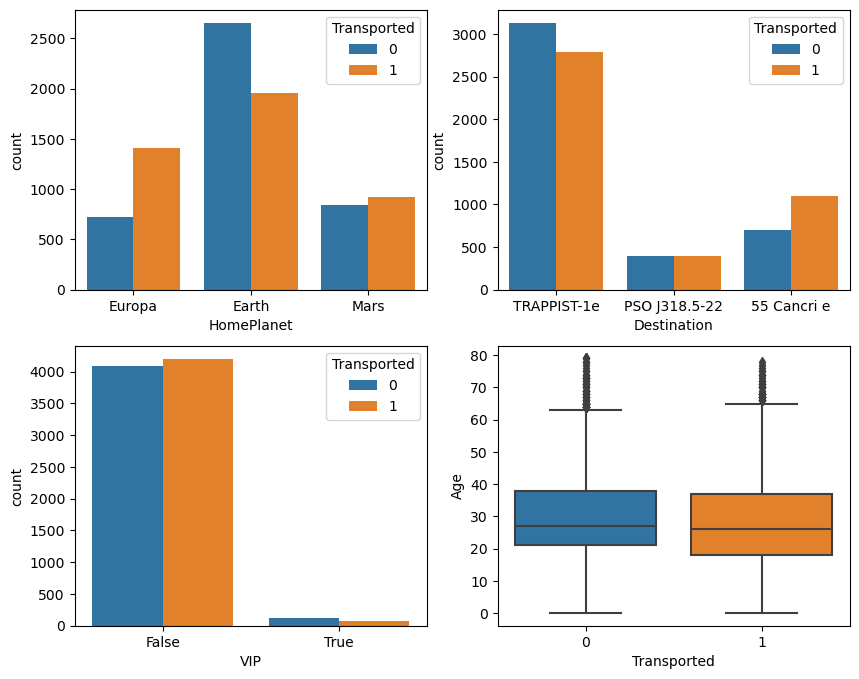

In [170]:
import seaborn as sns
fig,axs = plt.subplots(2,2, figsize=(10,8))
sns.countplot(data=df,hue=df['Transported'],x=df['HomePlanet'],ax=axs[0][0])
sns.countplot(data=df, x='Destination', hue='Transported',ax=axs[0][1])
sns.countplot(data=df, x='VIP', hue='Transported',ax=axs[1][0])
sns.boxplot(data=df,x=df['Transported'],y=df['Age'],ax=axs[1][1])

# sns.countplot(data=df,x=df['HomePlanet'],ax=axs[1])
plt.show()

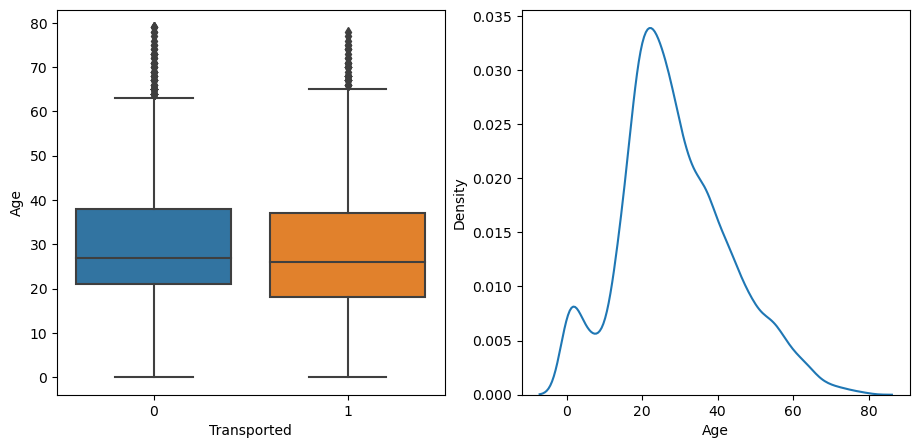

In [171]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxplot(data=df,x=df['Transported'],y=df['Age'],ax=axs[0])
sns.kdeplot(data=df,x=df['Age'],ax=axs[1])
plt.show()

In [172]:
def featureEng(X):
    X['Extras']=np.log1p(X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1))
    cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Age']
    X[['c1','c2','c3']]=X['Cabin'].str.split('/',expand=True)
    X.drop(['c2','Cabin'],axis=1,inplace=True)
    X[cols]=np.log1p(X[cols])
    return X

In [173]:
def afterFe():
    X_train=featureEng(df.copy())
    X_test=featureEng(df_test.copy())
    print('after Fe done')
    return (X_train,X_test)
    

In [509]:
X_train,X_test=afterFe()

after Fe done


In [510]:
X_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
Extras          float64
c1               object
c3               object
dtype: object

In [176]:
import subprocess
def make_sub(pred_y,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['PassengerId']=df_test['PassengerId']
    df_submission['Transported']=pred_y
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')


***
<font size="5"><b> Dumb model =Score: 0.50689 </b>
</font>
***


In [93]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Custom transformer for feature engineering
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

steps = [  # Custom feature engineering
    ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('feature_engineering', FeatureEngineeringTransformer()),
    ('encoder', OneHotEncoder()),# Replace missing values with the most frequent value
    ('scaler', StandardScaler()),  # Standardize the features
    ('classifier', RandomForestClassifier())  # Classifier for training
]

In [561]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_cols),
        ("numerical", numeric_preprocessor,num_cols),
    ]
)

pipe = make_pipeline(preprocessor, XGBClassifier())
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'c1', 'c3', 'Sname',
       'pid2'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipel...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [178]:
total_vip_passengers = df[df['VIP'] == True].shape[0]
vip_in_cryo_sleep = df[(df['VIP'] == True) & (df['CryoSleep'] == True)].shape[0]

percentage = (vip_in_cryo_sleep / total_vip_passengers) * 100
print(f"Percentage of VIP passengers in cryo sleep: {percentage:.2f}%")


total_vip_passengers = df[(df['VIP'] == True) & (df['CryoSleep'] == False)].shape[0]
vip_spent_money = X_train[(X_train['VIP'] == True) & (X_train['Extras'] >0)].shape[0]
percentage = (vip_spent_money / total_vip_passengers) * 100
print(f"Percentage of VIP spent: {percentage:.2f}%")

total_vip_passengers = df[(df['VIP'] == False) & (df['CryoSleep'] == False)].shape[0]
vip_spent_money = X_train[(X_train['VIP'] == False) & (X_train['Extras'] >0)].shape[0]
percentage = (vip_spent_money / total_vip_passengers) * 100
print(f"Percentage of non VIP spent: {percentage:.2f}%")

Percentage of VIP passengers in cryo sleep: 10.55%
Percentage of VIP spent: 97.71%
Percentage of non VIP spent: 92.53%


In [179]:
def missing_cryosleep(C):
    for index, row in C.iterrows():
        if pd.isnull(row['CryoSleep']) and row['Extras'] > 0:
            C.at[index, 'CryoSleep'] = False
        elif pd.isnull(row['CryoSleep']):
            C.at[index, 'CryoSleep'] = True
    return C


In [180]:
# X_test.loc[(X_test.CryoSleep.isna())]
X_test=missing_cryosleep(X_test.copy())
X_train=missing_cryosleep(X_train.copy())

In [181]:
X_train.loc[(X_train.CryoSleep.isna())]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3


In [182]:
X_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
Extras          float64
c1               object
c3               object
dtype: object

In [183]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3
0,0001_01,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P
1,0002_01,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S
2,0003_01,Europa,False,TRAPPIST-1e,4.08,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S
3,0003_02,Europa,False,TRAPPIST-1e,3.53,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S
4,0004_01,Earth,False,TRAPPIST-1e,2.83,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S


In [184]:
X_test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Extras,c1,c3
0,0013_01,Earth,True,TRAPPIST-1e,3.33,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning,0.00,G,S
1,0018_01,Earth,False,TRAPPIST-1e,3.00,False,0.00,2.30,0.00,7.95,0.00,Lerome Peckers,7.95,F,S
2,0019_01,Europa,True,55 Cancri e,3.47,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus,0.00,C,S
3,0021_01,Europa,False,TRAPPIST-1e,3.66,False,0.00,8.80,0.00,5.20,6.37,Meratz Caltilter,8.91,C,S
4,0023_01,Earth,False,TRAPPIST-1e,3.04,False,2.40,0.00,6.46,0.00,0.00,Brence Harperez,6.47,F,S


In [197]:
def spitting_Y(M):
    Y=M['Transported']
    M.drop('PassengerId', axis=1, inplace=True, errors='ignore')
    return X,Y

In [198]:
X,Y=spitting_Y(X_train.copy())

In [191]:
X=X_train.drop('PassengerId',axis=1,inplace=False)

In [199]:
X.dtypes
# print(Y.head(2))

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
Extras          float64
c1               object
c3               object
dtype: object

In [200]:
cat_cols = X.select_dtypes('object').columns
print(X_train.dtypes)

PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
Extras          float64
c1               object
c3               object
dtype: object


In [202]:
# X['RoomService'].unique()
df['RoomService'].isnull().sum()

181

In [203]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'c1', 'c3'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index([], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [244]:
preds=pipe.predict(X_test)

In [249]:
make_sub(preds_bool,name='rf-own-1')

100%|██████████| 56.5k/56.5k [00:00<00:00, 70.7kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - rf-own-1


In [34]:
def model_imp(model_name):
    model = pipe.named_steps[model_name]
    importances = model.feature_importances_
    importances
    feature_names = X.columns
    feature_importances = sorted(zip(importances, feature_names), reverse=True)
    k=20
    top_features = feature_importances[:k]
    features = [feature for importance, feature in top_features]
    importance_values = [importance for importance, feature in top_features]
    plt.figure(figsize=(10, 6))
    plt.bar(features, importance_values)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top Features')
    plt.xticks(rotation=45)
    plt.show()

In [204]:
from xgboost import XGBClassifier
pipe.steps[-1] = ('xgbclassifier', XGBClassifier())

In [205]:
pipe.fit(X, Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'c1', 'c3'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(step...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [271]:
preds=pipe.predict(X_test).astype(bool)

In [273]:
make_sub(preds,name='xgb')

100%|██████████| 56.4k/56.4k [00:00<00:00, 60.8kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - xgb


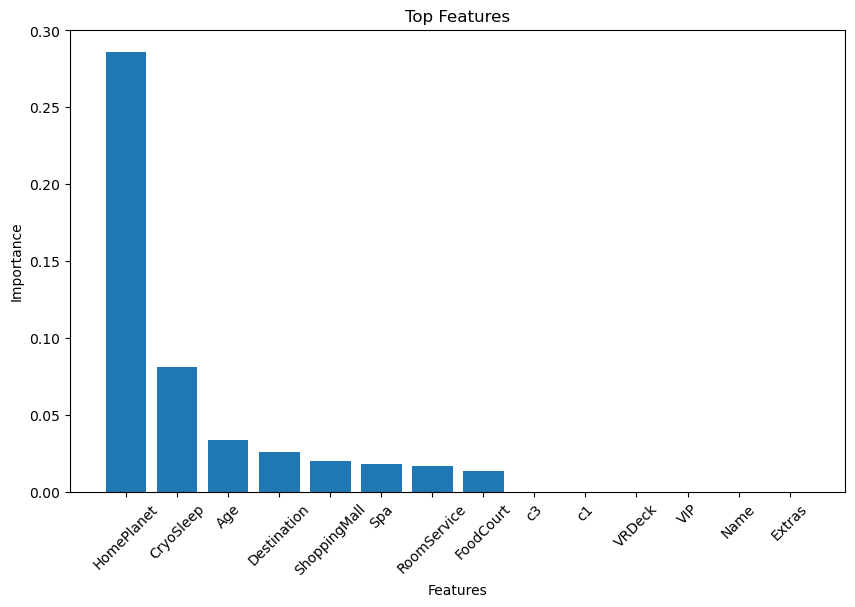

In [278]:
model_imp('xgbclassifier')

In [207]:
from catboost import CatBoostClassifier
model_1=CatBoostClassifier(iterations=1500,
                         eval_metric='Accuracy',
                        verbose=0)
pipe.steps[-1] = ('xgbclassifier', model_1)


In [208]:
pipe.fit(X, Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'c1', 'c3'], dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index([], dtype='object'))])),
                ('xgbclassifier',
                 <catboost.core.CatBoostClassifier object at 0x280869580>)])

In [209]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3
0,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P
1,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S
2,Europa,False,TRAPPIST-1e,4.08,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S
3,Europa,False,TRAPPIST-1e,3.53,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S
4,Earth,False,TRAPPIST-1e,2.83,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S


In [224]:
preds_y=pipe.predict(X_test).astype(bool)

In [226]:
make_sub(preds_y,name='catmodel')

100%|██████████| 56.9k/56.9k [00:00<00:00, 58.7kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - catmodel


In [241]:
dft=pd.DataFrame()
dft=X.copy()

In [242]:
dft.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3
0,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P
1,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S


In [243]:
dft['Age']=df['Age']

In [244]:
dft.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3
0,Europa,False,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P
1,Earth,False,TRAPPIST-1e,24.00,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S
2,Europa,False,TRAPPIST-1e,58.00,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S
3,Europa,False,TRAPPIST-1e,33.00,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S
4,Earth,False,TRAPPIST-1e,16.00,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S


In [258]:
age_intervals = [0,9, 12, 19,28,39, 49, 59,69, 100]
dft['AgeGroup'] = pd.cut(dft['Age'], bins=age_intervals, labels=False, right=False)
dft.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3,AgeGroup
0,Europa,False,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P,5.00
1,Earth,False,TRAPPIST-1e,24.00,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S,3.00
2,Europa,False,TRAPPIST-1e,58.00,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S,6.00
3,Europa,False,TRAPPIST-1e,33.00,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S,4.00
4,Earth,False,TRAPPIST-1e,16.00,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S,2.00
5,Earth,False,PSO J318.5-22,44.00,False,0.00,6.18,0.00,5.68,0.00,Sandie Hinetthews,1,6.65,F,P,5.00
6,Earth,False,TRAPPIST-1e,26.00,False,3.76,7.34,1.39,0.00,0.00,Billex Jacostaffey,1,7.37,F,S,3.00
7,Earth,True,TRAPPIST-1e,28.00,False,0.00,0.00,0.00,0.00,NaN,Candra Jacostaffey,1,0.00,G,S,4.00
8,Earth,False,TRAPPIST-1e,35.00,False,0.00,6.67,2.89,5.38,0.00,Andona Beston,1,6.93,F,S,4.00
9,Europa,True,55 Cancri e,14.00,False,0.00,0.00,0.00,0.00,0.00,Erraiam Flatic,1,0.00,B,P,2.00


In [259]:
dft['AgeGroup'] = dft['AgeGroup'].astype('object')

In [261]:
dft['AgeGroup'] = dft['AgeGroup'].apply(lambda x: f'Group {x + 1}')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Group 6.0'),
  Text(1, 0, 'Group 4.0'),
  Text(2, 0, 'Group 7.0'),
  Text(3, 0, 'Group 5.0'),
  Text(4, 0, 'Group 3.0'),
  Text(5, 0, 'Group 1.0'),
  Text(6, 0, 'Group 2.0'),
  Text(7, 0, 'Group 8.0'),
  Text(8, 0, 'Group nan'),
  Text(9, 0, 'Group 9.0')])

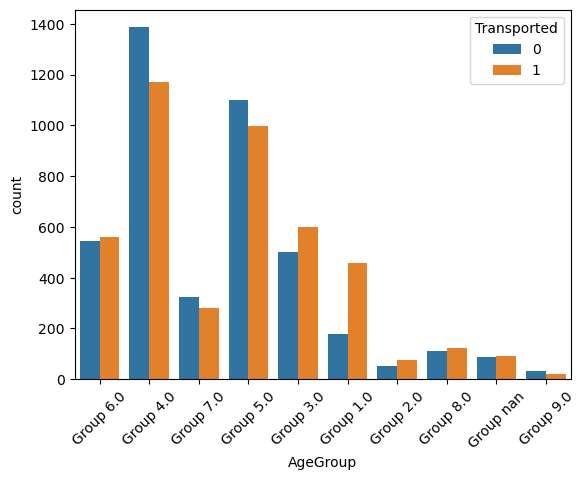

In [263]:
sns.countplot(data=dft, x='AgeGroup', hue='Transported')
plt.xticks(rotation=45)

In [256]:
dft.dtypes

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
Extras          float64
c1               object
c3               object
AgeGroup         object
dtype: object

In [264]:
X['Age']=dft['AgeGroup']

In [268]:
cat_cols = X.select_dtypes('object').columns
num_cols=X.select_dtypes('float64').columns
print(cat_cols)
print(num_cols)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Name', 'c1',
       'c3'],
      dtype='object')
Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Extras'], dtype='object')


In [270]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Name', 'c1',
       'c3'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Extras'], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [271]:
def Age_change(M):
    age_intervals = [0,9, 12, 19,28,39, 49, 59,69, 100]
    M['Age'] = pd.cut(dft['Age'], bins=age_intervals, labels=False, right=False)
    M['Age'] = M['Age'].apply(lambda x: f'Group {x + 1}')    
    return M

In [274]:
N=df_test.copy()

In [279]:
X_test['Age']=df_test['Age']

In [280]:
X_test=Age_change(X_test)

In [282]:
X_test.Age.value_counts()

Group 4.0    1251
Group 5.0    1008
Group 6.0     552
Group 3.0     529
Group 1.0     325
Group 7.0     306
Group 8.0     118
Group nan      92
Group 2.0      61
Group 9.0      35
Name: Age, dtype: int64

In [284]:
preds=pipe.predict(X_test).astype(bool)

In [286]:
make_sub(preds,name='rf1-age')

100%|██████████| 56.5k/56.5k [00:01<00:00, 55.4kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - rf1-age


In [292]:
# pipe.steps[-1] = ('xgbclassifier', XGBClassifier())

pipe.fit(X,Y)
preds=pipe.predict(X_test).astype(bool)
preds[:10]

array([ True, False,  True,  True, False, False,  True,  True,  True,
        True])

In [293]:
make_sub(preds,name='xgb-age')

100%|██████████| 56.3k/56.3k [00:00<00:00, 78.9kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - xgb-age


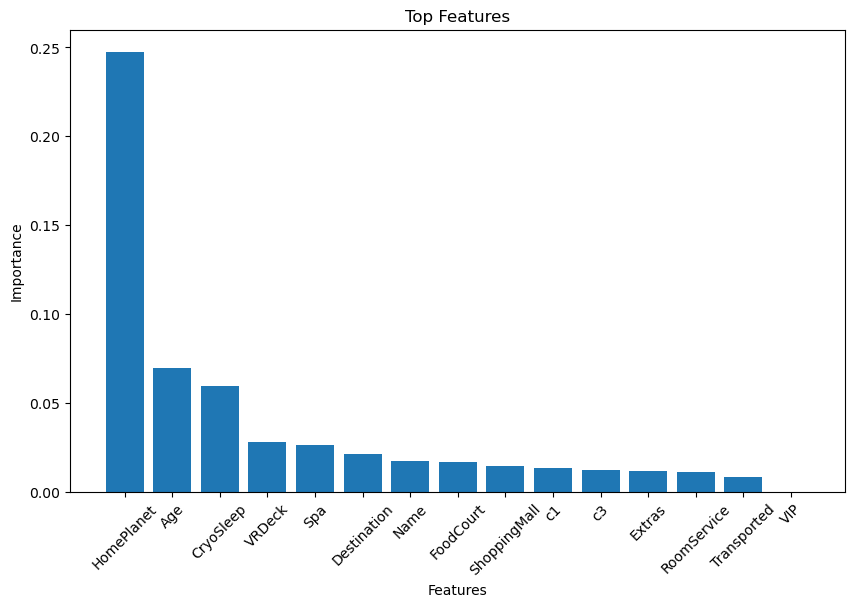

In [294]:
model_imp('xgbclassifier')

In [305]:
X_test.isna().sum()

HomePlanet       87
CryoSleep         0
Destination      92
Age               0
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Extras            0
c1              100
c3              100
dtype: int64

In [360]:
dft=X_train.copy()
dft['HP_na']=dft['HomePlanet'].isna()
dft.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3,HP_na
0,0001_01,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P,False
1,0002_01,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S,False
2,0003_01,Europa,False,TRAPPIST-1e,4.08,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S,False
3,0003_02,Europa,False,TRAPPIST-1e,3.53,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S,False
4,0004_01,Earth,False,TRAPPIST-1e,2.83,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S,False


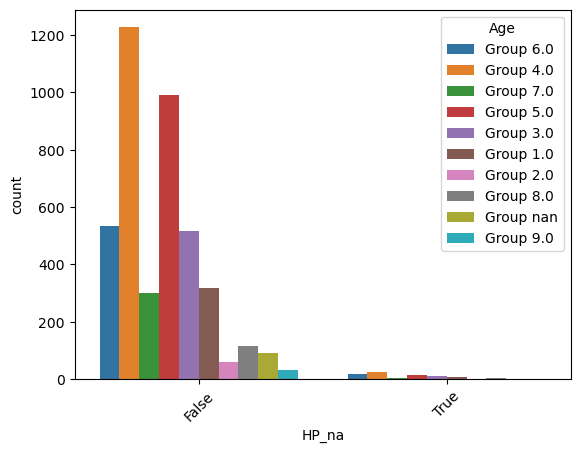

In [311]:
sns.countplot(data=dft, x='HP_na', hue='Age')
plt.xticks(rotation=45)
plt.show()

In [313]:
df['Homeplanet']

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Extras,c1,c3,HP_na
0,Earth,True,TRAPPIST-1e,Group 6.0,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning,0.00,G,S,False
1,Earth,False,TRAPPIST-1e,Group 4.0,False,0.00,2.30,0.00,7.95,0.00,Lerome Peckers,7.95,F,S,False
2,Europa,True,55 Cancri e,Group 7.0,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus,0.00,C,S,False
3,Europa,False,TRAPPIST-1e,Group 5.0,False,0.00,8.80,0.00,5.20,6.37,Meratz Caltilter,8.91,C,S,False
4,Earth,False,TRAPPIST-1e,Group 3.0,False,2.40,0.00,6.46,0.00,0.00,Brence Harperez,6.47,F,S,False


In [328]:
counts = dft.groupby(['HomePlanet','Age']).size()
sum_counts = counts.groupby(['HomePlanet','Age']).sum().nlargest(10)
print(sum_counts)

HomePlanet  Age      
Earth       Group 4.0    663
            Group 5.0    554
Europa      Group 4.0    308
Earth       Group 6.0    299
            Group 3.0    277
Mars        Group 4.0    256
Europa      Group 5.0    232
Mars        Group 5.0    206
Earth       Group 1.0    170
            Group 7.0    155
dtype: int64


In [331]:
counts = dft.groupby(['HomePlanet','VIP']).size()
sum_counts = counts.groupby(['HomePlanet','VIP']).sum().nlargest(10)
print(sum_counts)

HomePlanet  VIP  
Earth       False    2219
Europa      False     925
Mars        False     880
Europa      True       46
Mars        True       27
dtype: int64


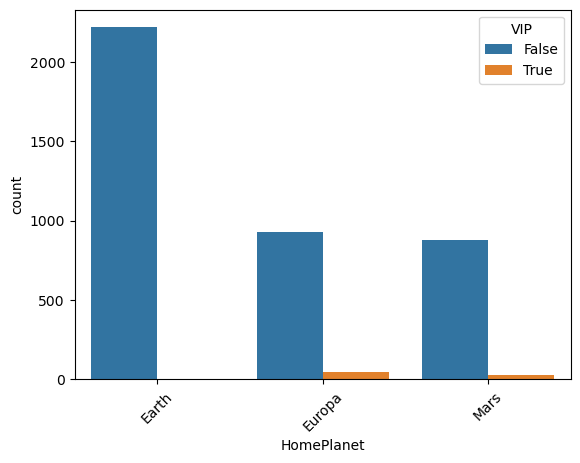

In [332]:
sns.countplot(data=dft, x='HomePlanet', hue='VIP')
plt.xticks(rotation=45)
plt.show()

In [338]:
dft[(dft["HomePlanet"].isna()) & (dft['VIP']==False)].Destination.value_counts()

TRAPPIST-1e      55
55 Cancri e      22
PSO J318.5-22     7
Name: Destination, dtype: int64

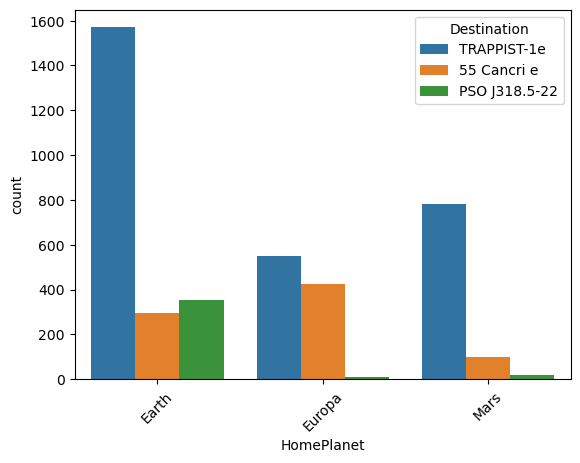

In [339]:
sns.countplot(data=dft, x='HomePlanet', hue='Destination')
plt.xticks(rotation=45)
plt.show()

In [343]:
dft['Name']=df['Name']

In [361]:
dft[['Fname','Sname']]=dft['Name'].str.split(' ',expand=True)

In [362]:
dft.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3,HP_na,Fname,Sname
0,0001_01,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P,False,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S,False,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,4.08,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S,False,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,3.53,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S,False,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,2.83,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S,False,Willy,Santantines


In [369]:
dft.Sname.value_counts()

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
              ..
Covale         1
Dun            1
Witalnerod     1
Deryplinet     1
Sionerorly     1
Name: Sname, Length: 2217, dtype: int64

In [374]:
counts = dft['Sname'].value_counts()
counts = counts[counts > 1]
print(counts)

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
              ..
Rushing        2
Miley          2
Amoutake       2
Oilpuring      2
Snoaf          2
Name: Sname, Length: 1835, dtype: int64


In [413]:
dft[dft['Sname']=='Oneiles']

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3,HP_na,Fname,Sname
183,0205_01,Earth,False,TRAPPIST-1e,3.40,False,0.00,1.10,4.20,0.00,6.56,Carma Oneiles,0,6.65,G,S,False,Carma,Oneiles
398,0437_01,Earth,False,TRAPPIST-1e,3.69,False,5.95,0.00,3.14,6.15,0.00,Lynnee Oneiles,0,6.77,F,S,False,Lynnee,Oneiles
399,0437_02,Earth,False,PSO J318.5-22,3.71,False,2.08,0.00,6.73,3.30,0.00,Debora Oneiles,0,6.77,F,S,False,Debora,Oneiles
1992,2130_01,Earth,False,PSO J318.5-22,2.64,False,0.00,1.10,6.18,2.40,5.18,Marine Oneiles,0,6.51,F,P,False,Marine,Oneiles
3124,3365_01,Earth,True,PSO J318.5-22,3.04,False,0.00,0.00,0.00,0.00,0.00,Jacki Oneiles,1,0.00,G,S,False,Jacki,Oneiles
4254,4529_01,Earth,False,55 Cancri e,3.78,False,3.30,4.89,1.39,4.77,6.32,Terald Oneiles,0,6.73,G,S,False,Terald,Oneiles
5513,5885_01,Earth,False,TRAPPIST-1e,3.74,False,2.20,6.28,0.00,0.00,4.62,Danna Oneiles,1,6.46,F,S,False,Danna,Oneiles
5514,5885_02,Earth,False,TRAPPIST-1e,4.03,False,0.00,0.00,0.00,6.23,6.81,Philia Oneiles,1,7.26,F,S,False,Philia,Oneiles
5515,5885_03,Earth,False,TRAPPIST-1e,3.40,False,0.00,7.78,2.08,3.04,1.95,Glena Oneiles,1,7.80,F,S,False,Glena,Oneiles
5516,5885_04,Earth,False,TRAPPIST-1e,3.00,False,0.00,0.00,0.00,6.79,0.00,Aliedy Oneiles,0,6.79,G,S,False,Aliedy,Oneiles


In [359]:
X_train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3
0,0001_01,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P
1,0002_01,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S
2,0003_01,Europa,False,TRAPPIST-1e,4.08,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S
3,0003_02,Europa,False,TRAPPIST-1e,3.53,False,0.00,7.16,5.92,8.11,5.27,Solam Susent,0,8.55,A,S
4,0004_01,Earth,False,TRAPPIST-1e,2.83,False,5.72,4.26,5.02,6.34,1.10,Willy Santantines,1,7.00,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,3.74,True,0.00,8.83,0.00,7.40,4.32,Gravior Noxnuther,0,9.05,A,P
8689,9278_01,Earth,True,PSO J318.5-22,2.94,False,0.00,0.00,0.00,0.00,0.00,Kurta Mondalley,0,0.00,G,S
8690,9279_01,Earth,False,TRAPPIST-1e,3.30,False,0.00,0.00,7.54,0.69,0.00,Fayey Connon,1,7.54,G,S
8691,9280_01,Europa,False,55 Cancri e,3.50,False,0.00,6.96,0.00,5.87,8.08,Celeon Hontichre,0,8.44,E,S


In [372]:
dft.shape

(8693, 19)

In [375]:
1835/2217

0.8276950834460983

In [390]:
dft.c3.isna().sum()

11

In [420]:
# import pandas as pd

# Replace 'dft' with the name of your DataFrame
for sname in dft['Sname'].dropna().unique():
    if dft['Sname'].value_counts()[sname] > 1:
        mode_vip = dft.loc[dft['Sname'] == sname, 'VIP'].mode()[0]
        mode_c3 = dft.loc[dft['Sname'] == sname, 'c3'].mode()[0]
        mode_home = dft.loc[dft['Sname'] == sname, 'HomePlanet'].mode()[0]
        mode_dest = dft.loc[dft['Sname'] == sname, 'Destination'].mode()[0]
        
        dft.loc[(dft['Sname'] == sname) & (dft['VIP'].isnull()), 'VIP'] = mode_vip
        dft.loc[(dft['Sname'] == sname) & (dft['c3'].isna()), 'c3'] = mode_c3
        dft.loc[(dft['Sname'] == sname) & (dft['HomePlanet'].isna()), 'HomePlanet'] = mode_home
        dft.loc[(dft['Sname'] == sname) & (dft['Destination'].isna()), 'Destination'] = mode_dest
        
        
#         print(mode_c3)

# print(dft)


In [398]:
N = 50  # Number of largest 'Sname' values to consider

top_sn = dft['Sname'].value_counts().nlargest(N).index
top_vip_counts = dft[dft['Sname'].isin(top_sn)]['VIP'].value_counts()
print(top_sn)
print(top_vip_counts)

# plt.bar(top_vip_counts.values,top_vip_counts.index)
# plt.xlabel('VIP Types')
# plt.ylabel('Count')
# plt.title(f'Top {N} Largest Sname - VIP Type Count')
# plt.xticks(rotation=45)
# plt.show()

Index(['Casonston', 'Oneiles', 'Domington', 'Litthews', 'Browlerson', 'Garnes',
       'Cartez', 'Fulloydez', 'Hinglendez', 'Distured', 'Briggston', 'Barbes',
       'Moodman', 'Gibbsonton', 'Vandan', 'Fowlesterez', 'Loway', 'Vloaf',
       'Gainney', 'Hanner', 'Georgasey', 'Wagnerray', 'Cofferson', 'Jenson',
       'Gouldensen', 'Morelly', 'Fryersonis', 'Ingston', 'Mosteraked',
       'Torrez', 'Buckentry', 'Chanan', 'Crité', 'Pirejus', 'Villenson',
       'Ousious', 'Clugete', 'Kiling', 'Ainserfle', 'Coolerson', 'Fla',
       'Clemondsey', 'Belley', 'Yorkland', 'Guerson', 'Willy', 'Haydenzier',
       'Mclardson', 'Wilsoney', 'Minen'],
      dtype='object')
False    582
True       3
Name: VIP, dtype: int64


In [421]:
dft.isna().sum()

PassengerId       0
HomePlanet       15
CryoSleep         0
Destination      12
Age             179
VIP               8
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Extras            0
c1              199
c3               11
HP_na             0
Fname           200
Sname           200
dtype: int64

In [417]:
dft.shape

(8693, 19)

In [418]:
X.shape

(8693, 15)

In [423]:
X.isna().sum()

HomePlanet       15
CryoSleep         0
Destination      12
Age               0
VIP               8
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Extras            0
c1              199
c3               11
dtype: int64

In [422]:
cols=['HomePlanet','Destination','c3','VIP']
X[cols]=dft[cols]

In [424]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Name', 'c1',
       'c3'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipelin...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [425]:
X_test.isna().sum()

HomePlanet       87
CryoSleep         0
Destination      92
Age               0
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Extras            0
c1              100
c3              100
dtype: int64

In [426]:
dftt=X_test.copy()

In [427]:
dftt.isna().sum()

HomePlanet       87
CryoSleep         0
Destination      92
Age               0
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Extras            0
c1              100
c3              100
dtype: int64

In [448]:
def missing_inter(M):
    for sname in M['Sname'].dropna().unique():
        try:
            if (M['Sname'].value_counts()[sname] > 1):
                mode_vip = M.loc[M['Sname'] == sname, 'VIP'].mode()[0]
                mode_c3 = M.loc[M['Sname'] == sname, 'c3'].mode()[0]
                mode_home = M.loc[M['Sname'] == sname, 'HomePlanet'].mode()[0]
                mode_dest = M.loc[M['Sname'] == sname, 'Destination'].mode()[0]

                M.loc[(M['Sname'] == sname) & (M['VIP'].isnull()), 'VIP'] = mode_vip
                M.loc[(M['Sname'] == sname) & (M['c3'].isna()), 'c3'] = mode_c3
                M.loc[(M['Sname'] == sname) & (M['HomePlanet'].isna()), 'HomePlanet'] = mode_home
                M.loc[(M['Sname'] == sname) & (M['Destination'].isna()), 'Destination'] = mode_dest
        except:
            continue
    return M

In [433]:
dftt[['Fname','Sname']]=dftt['Name'].str.split(' ',expand=True)

In [444]:
dftt[dftt['HomePlanet'].isna()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Extras,c1,c3,Fname,Sname
276,NaN,False,TRAPPIST-1e,Group 4.0,False,0.00,6.06,NaN,7.05,6.93,Arkaban Spriney,7.87,E,S,Arkaban,Spriney
340,NaN,False,TRAPPIST-1e,Group 3.0,False,2.71,0.00,7.51,1.10,5.15,Skunch Ponie,7.60,F,S,Skunch,Ponie
450,NaN,False,TRAPPIST-1e,Group 4.0,False,0.00,1.61,0.00,6.60,0.69,Anniey Currisones,6.60,F,S,Anniey,Currisones
464,NaN,False,TRAPPIST-1e,Group 6.0,False,0.69,0.00,0.00,0.00,6.45,Andan Fryan,6.45,F,S,Andan,Fryan
481,NaN,False,TRAPPIST-1e,Group 5.0,False,0.00,6.13,5.02,5.55,0.00,Mara Ments,6.76,F,S,Mara,Ments
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957,NaN,False,TRAPPIST-1e,Group 5.0,False,1.61,0.00,7.38,0.00,0.00,Vanley Simmonders,7.38,E,P,Vanley,Simmonders
3980,NaN,True,55 Cancri e,Group 4.0,False,0.00,0.00,0.00,0.00,0.00,Eilan Kellson,0.00,G,S,Eilan,Kellson
4032,NaN,True,TRAPPIST-1e,Group 4.0,False,0.00,0.00,0.00,0.00,0.00,Raston Maltorted,0.00,D,P,Raston,Maltorted
4159,NaN,False,TRAPPIST-1e,Group 5.0,False,0.00,0.00,3.37,6.59,0.00,Ale Whitersone,6.63,G,S,Ale,Whitersone


In [449]:
dft2=missing_inter(dftt.copy())
# dft2.isna().sum()

In [450]:
dft2.isna().sum()

HomePlanet       22
CryoSleep         0
Destination      14
Age               0
VIP              21
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Extras            0
c1              100
c3               17
Fname            94
Sname            94
dtype: int64

In [451]:
cols

['HomePlanet', 'Destination', 'c3', 'VIP']

In [452]:
X_test[cols]=dft2[cols]

In [456]:
X_test.isna().sum()

HomePlanet       22
CryoSleep         0
Destination      14
Age               0
VIP              21
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Extras            0
c1              100
c3               17
dtype: int64

In [453]:
preds_c=pipe.predict(X_test).astype(bool)

In [455]:
make_sub(preds_c,name='after_conversion_xgb')

100%|██████████| 56.4k/56.4k [00:00<00:00, 65.9kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - after_conversion_xgb


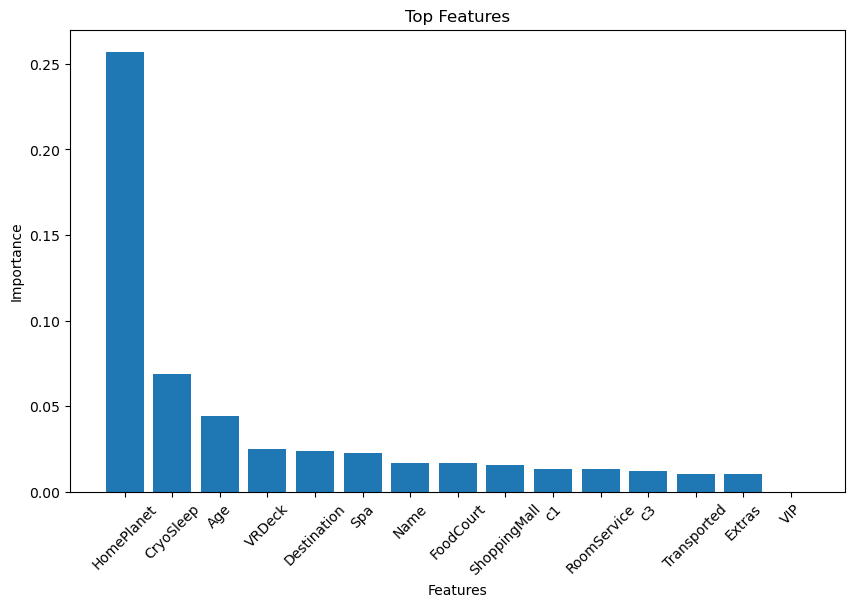

In [457]:
model_imp('xgbclassifier')

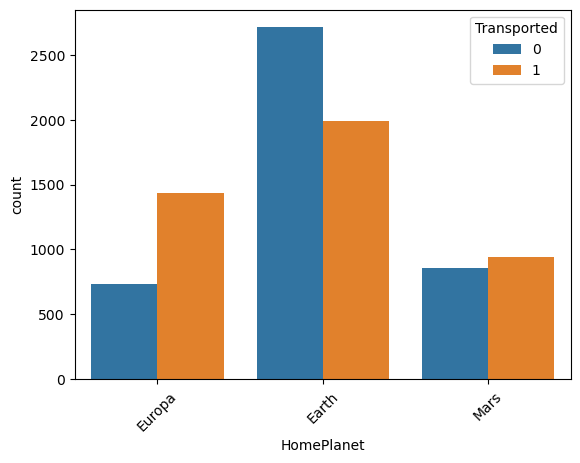

In [458]:
sns.countplot(data=dft, x='HomePlanet', hue='Transported')
plt.xticks(rotation=45)
plt.show()

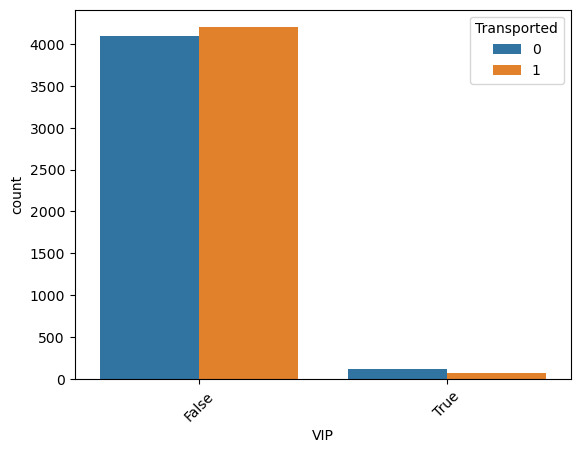

In [462]:
sns.countplot(data=X_train, x='VIP', hue='Transported')
plt.xticks(rotation=45)
plt.show()

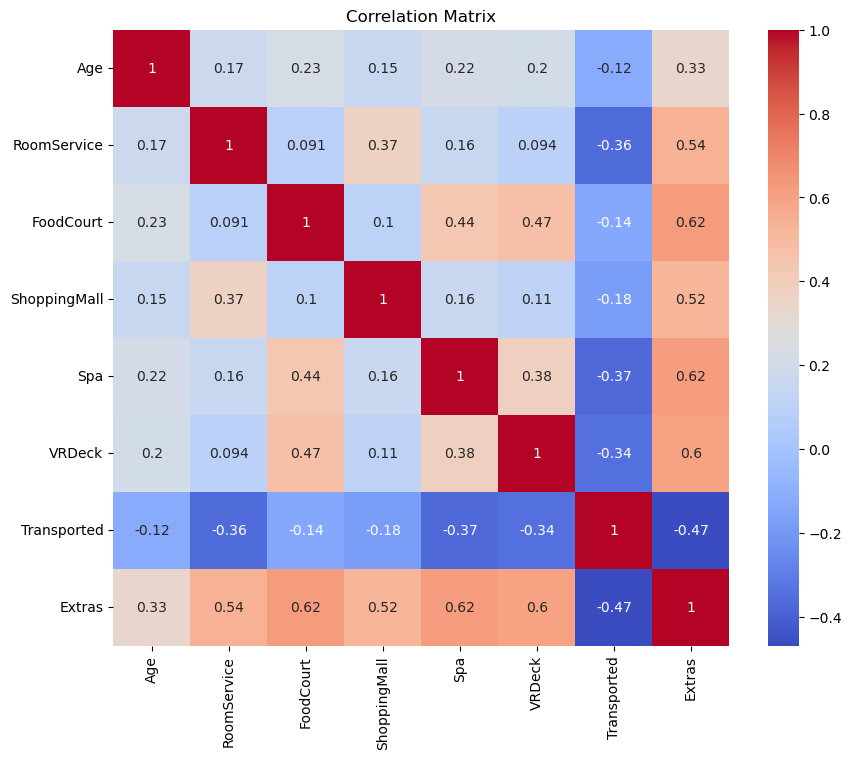

In [464]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [499]:
X.head()

AttributeError: 'Index' object has no attribute 'head'

In [470]:
dft['PassengerId']=X_train['PassengerId']

In [474]:
dft[['pid1','pid2']]=dft['PassengerId'].str.split('_',expand=True)

In [476]:
dft.pid2.value_counts()

01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: pid2, dtype: int64

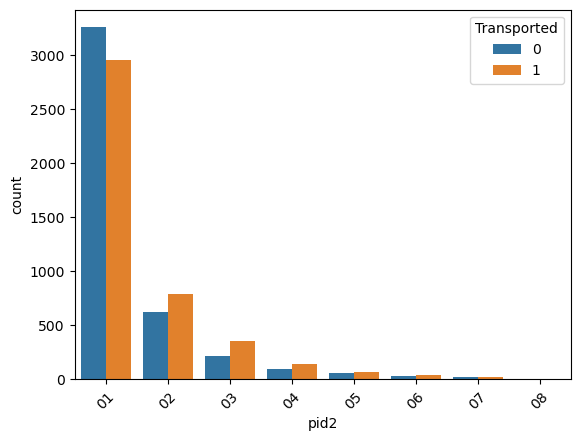

In [479]:
sns.countplot(data=dft, x='pid2', hue='Transported')
plt.xticks(rotation=45)
plt.show()

In [492]:
cat_cols = X.select_dtypes('object').columns
num_cols=X.select_dtypes('float64').columns
print(cat_cols)
print(num_cols)

AttributeError: 'Index' object has no attribute 'select_dtypes'

In [498]:
X['pid2']=dft['pid2']

TypeError: Index does not support mutable operations

In [482]:
dftt.shape

(4277, 17)

In [483]:
X_test.shape

(4277, 14)

In [487]:
dftt[['pid1','pid2']]=df_test['PassengerId'].str.split('_',expand=True)

In [488]:
X_test['pid2']=dftt['pid2']

In [489]:
X_test.shape

(4277, 15)

In [508]:
def missing_inter(M):
    for sname in M['Sname'].dropna().unique():
        try:
            if (M['Sname'].value_counts()[sname] > 1):
                mode_vip = M.loc[M['Sname'] == sname, 'VIP'].mode()[0]
                mode_c3 = M.loc[M['Sname'] == sname, 'c3'].mode()[0]
                mode_home = M.loc[M['Sname'] == sname, 'HomePlanet'].mode()[0]
                mode_dest = M.loc[M['Sname'] == sname, 'Destination'].mode()[0]

                M.loc[(M['Sname'] == sname) & (M['VIP'].isnull()), 'VIP'] = mode_vip
                M.loc[(M['Sname'] == sname) & (M['c3'].isna()), 'c3'] = mode_c3
                M.loc[(M['Sname'] == sname) & (M['HomePlanet'].isna()), 'HomePlanet'] = mode_home
                M.loc[(M['Sname'] == sname) & (M['Destination'].isna()), 'Destination'] = mode_dest
        except:
            continue
    for index, row in M.iterrows():
        if pd.isnull(row['CryoSleep']) and row['Extras'] > 0:
            M.at[index, 'CryoSleep'] = False
        elif pd.isnull(row['CryoSleep']):
            M.at[index, 'CryoSleep'] = True
    age_intervals = [0,9, 12, 19,28,39, 49, 59,69, 100]
    M['Age'] = pd.cut(M['Age'], bins=age_intervals, labels=False, right=False)
    return M

In [535]:
def cols_add(M,N):
    M[['Fname','Sname']]=N['Name'].str.split(' ',expand=True)    
    M[['pid1','pid2']]=N['PassengerId'].str.split('_',expand=True)  
    M.drop(['Fname','pid1','Name','PassengerId'],axis=1,inplace=True)
    return M

In [536]:
X_train.head(3)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Extras,c1,c3,Sname,pid2
0,0001_01,Europa,False,TRAPPIST-1e,3.69,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0,0.00,B,P,Ofracculy,01
1,0002_01,Earth,False,TRAPPIST-1e,3.22,False,4.70,2.30,3.26,6.31,3.81,Juanna Vines,1,6.60,F,S,Vines,01
2,0003_01,Europa,False,TRAPPIST-1e,4.08,True,3.78,8.18,0.00,8.81,3.91,Altark Susent,0,9.25,A,S,Susent,01


In [537]:
X_test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Extras,c1,c3
0,0013_01,Earth,True,TRAPPIST-1e,3.33,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning,0.00,G,S
1,0018_01,Earth,False,TRAPPIST-1e,3.00,False,0.00,2.30,0.00,7.95,0.00,Lerome Peckers,7.95,F,S
2,0019_01,Europa,True,55 Cancri e,3.47,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus,0.00,C,S
3,0021_01,Europa,False,TRAPPIST-1e,3.66,False,0.00,8.80,0.00,5.20,6.37,Meratz Caltilter,8.91,C,S
4,0023_01,Earth,False,TRAPPIST-1e,3.04,False,2.40,0.00,6.46,0.00,0.00,Brence Harperez,6.47,F,S


In [538]:
X=cols_add(X_train.copy(),X_train.copy())

In [539]:
X=missing_inter(X.copy())

In [540]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Extras,c1,c3,Sname,pid2
0,Europa,False,TRAPPIST-1e,0.00,False,0.00,0.00,0.00,0.00,0.00,0,0.00,B,P,Ofracculy,01
1,Earth,False,TRAPPIST-1e,0.00,False,4.70,2.30,3.26,6.31,3.81,1,6.60,F,S,Vines,01
2,Europa,False,TRAPPIST-1e,0.00,True,3.78,8.18,0.00,8.81,3.91,0,9.25,A,S,Susent,01
3,Europa,False,TRAPPIST-1e,0.00,False,0.00,7.16,5.92,8.11,5.27,0,8.55,A,S,Susent,02
4,Earth,False,TRAPPIST-1e,0.00,False,5.72,4.26,5.02,6.34,1.10,1,7.00,F,S,Santantines,01


In [541]:
X.shape

(8693, 16)

In [542]:
X_test.shape

(4277, 15)

In [543]:
X_test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Extras,c1,c3
0,0013_01,Earth,True,TRAPPIST-1e,3.33,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning,0.00,G,S
1,0018_01,Earth,False,TRAPPIST-1e,3.00,False,0.00,2.30,0.00,7.95,0.00,Lerome Peckers,7.95,F,S
2,0019_01,Europa,True,55 Cancri e,3.47,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus,0.00,C,S
3,0021_01,Europa,False,TRAPPIST-1e,3.66,False,0.00,8.80,0.00,5.20,6.37,Meratz Caltilter,8.91,C,S
4,0023_01,Earth,False,TRAPPIST-1e,3.04,False,2.40,0.00,6.46,0.00,0.00,Brence Harperez,6.47,F,S


In [544]:
X_test=cols_add(X_test.copy(),X_test.copy())

In [545]:
X_test.shape

(4277, 15)

In [547]:
X_test=missing_inter(X_test.copy())

In [563]:
X_test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Extras,c1,c3,Sname,pid2
0,Earth,True,TRAPPIST-1e,0.00,False,0.00,0.00,0.00,0.00,0.00,0.00,G,S,Carsoning,01
1,Earth,False,TRAPPIST-1e,0.00,False,0.00,2.30,0.00,7.95,0.00,7.95,F,S,Peckers,01
2,Europa,True,55 Cancri e,0.00,False,0.00,0.00,0.00,0.00,0.00,0.00,C,S,Unhearfus,01
3,Europa,False,TRAPPIST-1e,0.00,False,0.00,8.80,0.00,5.20,6.37,8.91,C,S,Caltilter,01
4,Earth,False,TRAPPIST-1e,0.00,False,2.40,0.00,6.46,0.00,0.00,6.47,F,S,Harperez,01


In [549]:
Y=X['Transported']
X.drop('Transported',axis=1,inplace=True)

In [550]:
X.shape

(8693, 15)

In [555]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

In [552]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Extras,c1,c3,Sname,pid2
0,Europa,False,TRAPPIST-1e,0.00,False,0.00,0.00,0.00,0.00,0.00,0.00,B,P,Ofracculy,01
1,Earth,False,TRAPPIST-1e,0.00,False,4.70,2.30,3.26,6.31,3.81,6.60,F,S,Vines,01
2,Europa,False,TRAPPIST-1e,0.00,True,3.78,8.18,0.00,8.81,3.91,9.25,A,S,Susent,01
3,Europa,False,TRAPPIST-1e,0.00,False,0.00,7.16,5.92,8.11,5.27,8.55,A,S,Susent,02
4,Earth,False,TRAPPIST-1e,0.00,False,5.72,4.26,5.02,6.34,1.10,7.00,F,S,Santantines,01


In [559]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols=X.select_dtypes(include=['float64']).columns
print(cat_cols)
print(num_cols)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'c1', 'c3', 'Sname',
       'pid2'],
      dtype='object')
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Extras'],
      dtype='object')


In [560]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Extras,c1,c3,Sname,pid2
0,Europa,False,TRAPPIST-1e,0.00,False,0.00,0.00,0.00,0.00,0.00,0.00,B,P,Ofracculy,01
1,Earth,False,TRAPPIST-1e,0.00,False,4.70,2.30,3.26,6.31,3.81,6.60,F,S,Vines,01
2,Europa,False,TRAPPIST-1e,0.00,True,3.78,8.18,0.00,8.81,3.91,9.25,A,S,Susent,01
3,Europa,False,TRAPPIST-1e,0.00,False,0.00,7.16,5.92,8.11,5.27,8.55,A,S,Susent,02
4,Earth,False,TRAPPIST-1e,0.00,False,5.72,4.26,5.02,6.34,1.10,7.00,F,S,Santantines,01


In [562]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_constant',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'c1', 'c3', 'Sname',
       'pid2'],
      dtype='object')),
                                                 ('numerical',
                                                  Pipel...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [564]:
preds=pipe.predict(X_test).astype(bool)
preds[:10]

array([ True, False,  True,  True,  True, False,  True,  True,  True,
        True])

In [565]:
make_sub(preds,name='xgbC')

100%|██████████| 56.3k/56.3k [00:00<00:00, 57.9kB/s]


Successfully submitted to Spaceship Titanicsuccesully saved - xgbC


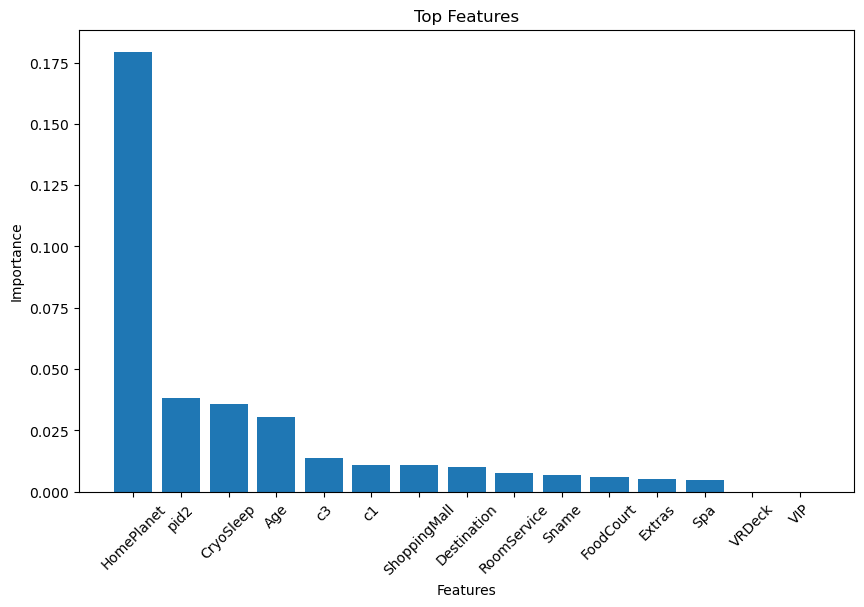

In [566]:
# xgb_classifier = pipe.named_steps['xgbclassifier']
model_imp('xgbclassifier')

In [567]:
from sklearn.metrics import confusion_matrix

y_pred = pipe.predict(X)

# Compute the confusion matrix
cm = confusion_matrix(df['Transported'], y_pred)

print(cm)

[[3604  711]
 [ 489 3889]]
[[3604  711]
 [ 489 3889]]


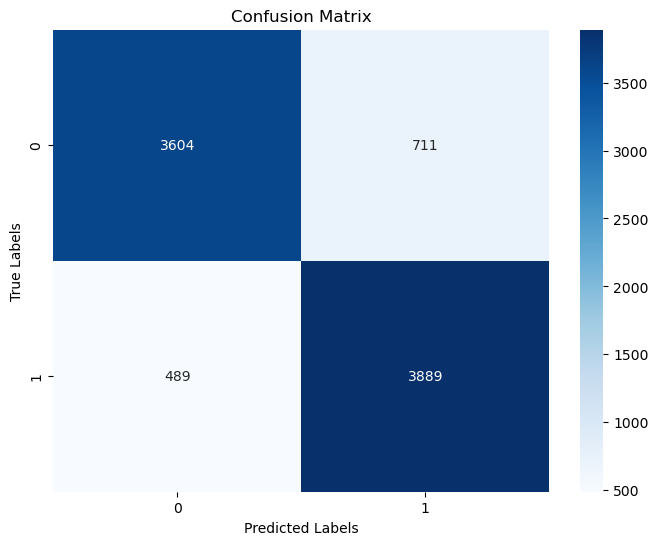

In [568]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()